# Development of the elements of the credit policy of the small bank with bootstrapping

Cyrill A. Murashev, 2023-02-19

## Abstract

This material is a continuation of a cycle of work on the topic of resampling methods. We discussed the jackknife method in the previous article. Today we will look at the more popular and universal method of bootstrapping. It would not be an exaggeration to say that bootstrapping is one of the cornerstones of modern data science, along with, for example, linear regression or ROC analysis. This material was developed specifically for appraisers, so we will look at the topic from the point of view of its practical usability in the practice of collateral lending.

Let's imagine a small bank operating in Eastern Europe. Its management has set a goal to develop a system of rules for the bank's credit policy. One of them should solve the task of determining the maximum price of the mortgaged property, which is safe for the financial stability of the bank. It was decided to take into account the modern reality, especially the latest achievements in the world of artificial intelligence, as well as the requirements of [IFRS 13 "Fair Value Measurement"](https://www.ifrs.org/issued-standards/list-of-standards/ifrs-13-fair-value-measurement/). Thus, it was decided to minimize the influence of subjective factors and maximize the influence of scientific methods. Since the capabilities of the small financial institution are rather limited, there is no opportunity to implement the full-scale AI methods based on a real big data. Instead, it is reasonable to implement some local solutions based on machine learning and apply them to the medium-sized sample.

It is very important to understand the following:
1. we are dealing with a sample data, not with the whole market data;
1. our goal is to estimate some parameters of the market, not only for the sample.
In this context, we should apply some special methods that can help us to bring the estimates of parameters made for the sample closer to the true values that exist on the market under consideration.

Today we will explore the method of bootstrapping in its basic implementation. It allows us to improve almost any estimate made for the sample and reduce its bias relative to the true value that exists in the market.





## Task statement and key inputs

As mentioned above, our training task is to develop some aspects of a bank's credit policy. Imagine a local market for real estate. The bank often makes loans secured by this property. In this case, one of the tasks is to set limits for the maximum possible loan amount, as well as the maximum safe value of the collateral. Both of these conditions are conditioned by the need to limit potential losses. And the second is also conditioned by the low liquidity of atypical objects, including those whose absolute or unit price is too high. In addition, insurance companies usually have their own limits, and they would not accept the risk of an excessive insurance payout, shifting it to the insured in the part of exceeding the limit. Therefore, it is reasonable to set the upper limit of the mortgaged property. In this case, the property with a value lower than the limit would be accepted as collateral for its full value. And a property with a value higher than the limit would be accepted at the limit value. This applies to both total and unit values.

In order to achieve a balance between financial security and profitability, the best choice is to determine the market values of safe limits. This task requires estimation of certain specific parameters of the whole market. Since we have only a sample, we should apply some special methods that will help us to correct the bias between sample and population estimates. Now we can create a system of rules. 
1. The upper limit of the total value of the property is equal to the expectation plus one standard deviation.
1. The upper limit of the unit value of the property is equal to the expectation plus two standard deviations.

The specific values of the standard deviation could be shifted in one direction or the other, depending on a bank's objectives.

Then we will estimate the values of the necessary parameters. We should estimate the true values of the four parameters: total and unit market values, as well as their standard deviations. As mentioned above, we can't get true values directly because we're working with samples. Therefore, we will use the method of bootstrapping, which allows us to reduce the bias of the sample estimates relative to the true values that exist in the population.

## Description of the method

### The General Statements of Bootstrapping

**Bootstrapping** is a random sampling with replacement technique. It belongs to the broader class of resampling methods. This technique can be used to estimate the sampling distribution of almost any statistic.

In practice, when analyzing data, appraisers are almost always faced with the need to estimate the variance and confidence intervals of some measure. It is difficult to make useful inferences based on point estimates alone. Therefore, it is very useful to be able to estimate the confidence intervals of any indicators. Classical statistics tells us that we can, for example, estimate confidence intervals for the mean under certain assumptions. But it does not give a simple answer to the question of what to do if these assumptions are violated. Estimating confidence intervals for the median is a much more complex problem in itself. So we need a universal method that allows us to estimate almost any parameter and obtain its variance and confidence intervals regardless of any assumptions about the distribution of that parameter.

The method of bootstrapping successfully solves the problem of obtaining values of such indicators regardless of the data distribution. Moreover, it allows you to improve any sample estimates, bringing their values closer to the true values in the population.

Let's imagine that there is some general population that has N elements. But we only have a sample of size n. If the N and n are the same, we can just get any parameter directly from the sample. In practice, the n is just almost far smaller than the N. So, we need to apply some function 'F(X)' to obtain estimates of some parameter for the sample. In the case where we know the distribution of the parameter in the general population, we can use the obtained point estimate. But more often than not, we do not know this distribution. In this case, the resulting point estimate is not useful enough for us. The fact is that we cannot somehow correlate it with the true value of the parameter for the entire general population. So we need to somehow get not only the estimate, but also its expected distribution in the population. That is, we should get a set of estimates as if we had many samples. But we only have one sample. So we need some kind of resampling. The summary of the above is shown in the figure below.

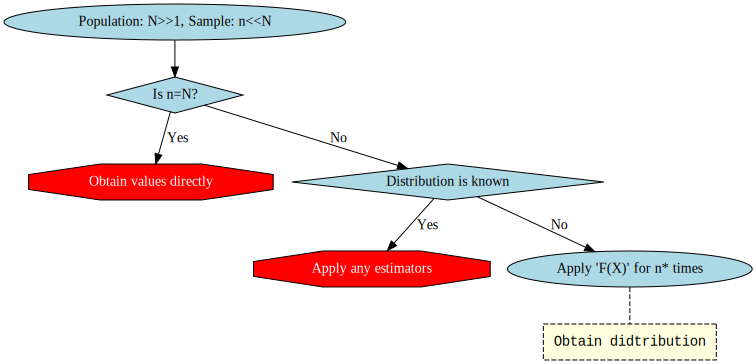

In [1]:
from flowgiston import *
Base = flowgiston_base(fillcolor='lightblue')
class Yes(Base):
    fillcolor = 'Red'
    fontcolor = 'white'
    shape = 'octagon'

class Note(Base):
    fillcolor = 'lightyellow'
    style = 'filled,dashed'
    shape = 'box'
    fontname = 'courier'

chart = FlowgistonChart(Base)

sample = chart.start("Population: N>>1, Sample: n<<N").edge(chart.if_("Is n=N?"))
sample.yes(chart.Yes.node("Obtain values directly"))
distribution = sample.no(chart.if_("Distribution is known"))
distribution.yes(chart.Yes.node("Apply any estimators"))
end = distribution.no(chart.end("Apply 'F(X)' for n* times")).edge(chart.Note.node("Obtain didtribution"), style='dashed', dir='none')
chart

Let's look at an example. We need to find the distribution of the following parameter
$$\frac{\overline{x}-\mu}{\frac{S}{\sqrt{n}}}.$$

Based on the flowchart above, we are forced to reject direct estimation. Then we can choose between the classical statistical approach and resampling. The first requires that we know the distribution. Or we can make some assumptions about the distribution. For example, we can assume that the estimated characteristic has a normal distribution in the general population. Then our parameter would have the t-distribution. But we have no answer to what would happen if our assumptions were wrong.

In valuation practice, we almost always do not know the distribution of a feature in the market and cannot make reliable guesses about it. Bootstrapping can help us in such a case. The idea is as follows. We have only one sample. Therefore, we can only get the point estimate of the parameter. But if we were able to get some number of samples from the general population, we would also be able to get the distribution of the parameter in them. This, in turn, would allow us to obtain the confidence intervals of the parameter, regardless of any assumptions. In practice, we are not able to get new samples without losses in size. But we can simulate new pseudo-samples as if we could get some samples from the population.

If our sample is large enough, its distribution is to some extent a reflection of the distribution in the general population. This fact allows us to make an important step in understanding the concept of bootstrapping, as well as the general concept of resampling. The classical statistical approach relies on a prior assumption about the shape of the distribution in the general population. Resampling methods, on the other hand, assume that the distribution in the general population is approximately the same as the sampling distribution. In a more general sense, we can say that the method involves working with the sample as if it were the general population. We take a sample and assume that it reflects the distribution of the population. Then we apply some resampling techniques. Then we use the function to calculate the statistics we are interested in. As a result, we extend the conclusions drawn from the sample to the entire population. The described technique looks a bit recursive. However, it works very well in practice.

### The technique of bootstrapping

Let's consider a simple case, the more advanced version of which will be useful for our main task. We have a sample $X[x_{1}\ldots x_{n}]$ and want to find the confidence interval for the mean. Of course, we have no problem calculating the sample mean. However, it's just a single number that relates only to the sample itself. The classical approach tells us that we can get the confidence interval from this value. But only if the distribution is known. In practice, we have no idea about the true distribution in the market. Therefore, it is very likely that the calculated confidence interval will be misleading. Instead, we will assume that the sample is fairly representative and to some extent reflects the true distribution in the population. Next, we will take the following steps.
1. We take our sample and use random sampling with replacement to create a new sample of the same size. This means that one or more observations from the original sample can be repeated any number of times in the new sample.
1. Repeat the previous step at least a thousand times. The more times you repeat this process, the better the result. Thus, the upper limit of repetitions is set only by the computing power.
1. Let's introduce some new notation and label the new sample as $X^{*}$. So we now have a set of $X^{*}$ from $X_{1}^{*}$ to $X_{B}^{*}$.
1. Calculate the statistic of interest for each $X^{*}$. In our case, it will be the mean. This will give us a set of values $\overline{X_{1}^{*}},\ldots,\overline{X_{B}^{*}}$.
1. It is easy to see that we now have the distribution of the statistic of interest. This allows us to work with it as we would with any known distribution. For example, we can set quantiles of interest and calculate the confidence interval, which was our original goal.

The above algorithm allows us to provide an implementation of the **percentile bootstrap**. It is the simplest and most intuitive type of bootstrapping. But it has some limitations. The main one is that this technique can only handle symmetric distributions well. The more sophisticated but also more universal technique is the **basic bootstrap**. This approach uses a slightly different technique. It has the same first two steps. But in the third step we calculate a different statistic:$\overline{X} - \overline{X_{i}^{*}}$. As a result, we get the distribution of the following statistic
$$\overline{X} - \overline{X_{i}^{*}}.$$
Its main idea is that we should achieve the following due to a very large number of repeated samples 
$$\mu - \overline{X} \approx \overline{X} - \overline{X^{*}}.$$
Let's label the distribution of $\mu - \overline{X}$ as $\beta$. If we knew alpha, we could get its quantiles, for example $\beta_{0.025}, \beta_{0.975}$. This means that we could estimate the probability of the following
$$
P\left(\mu-(\overline{x}) \in [\beta_{0.025}, \beta_{0.975}]\right)
$$
Of course, for the known beta, the probability is 0.95. The previous equation can be rewritten as follows
$$\begin{cases}
\mu-\overline{x} \leq \beta_{0.975}\\
\mu-\overline{x} \geq \beta_{0.025}.
\end{cases}
$$
It gives us the knowledge that
$$
P\left(\mu \in [\beta_{0.025}+\overline{x}, \beta_{0.975}++\overline{x}]\right).
$$
Thus, we obtain the distribution of the population by bootstrap approximation and estimate the confidence intervals.

#### Testing hypotheses

The universality of bootstrapping is that it allows not only to obtain a statistic, but also to test hypotheses. Let us consider an example. Let us have two samples: $X=x_{1},\ldots,x_{n}$ and $Y=y_{1},\ldots,y_{m}$. And we want to test if the expectations of X and Y are equal: $\mu_{X}=\mu_{Y}\ -\ ?$. However, all we can get are the sample means. The well-known t-test can do the job, but it also has a well-known limitation. It is based on the assumption of a normal distribution of the characteristic in both samples. However, our distributions are unknown. Bootstrapping will help us to overcome this limitation. The basic approach is the same as in classical statistics. We construct null and alternative hypotheses. Then we estimate the distribution of the resulting statistic for the case where the null hypothesis is true. But the hypotheses themselves are a bit exotic. The null hypothesis is that the distributions of the *X* and *Y* are equal.
1. Combine the two samples into one, keeping the data about the origin of each observation.
1. Generate new sample of size *m+n* by resampling with replacement.
1. Divide it into two samples by the trait of origin.
1. Calculate $\overline{X_{i}^{*}}$ and $\overline{Y_{j}^{*}}$.
1. Subtract $\overline{Y_{j}^{*}}$ from $\overline{X_{i}^{*}}$.
1. Repeat steps 2 through 5 *k* times *(k>1000)*.
1. Now we have the distribution of the differences between $X^{*}$ and $Y^{*}$.
1. All we need now is to subtract Y from X and find the probability *(p-value)* of such a difference for our distribution obtained in the previous step.
1. Next, we compare the p-value to the $\alpha$ (the most common is 0.05) and make a decision whether to reject the null hypothesis. 
The last two steps are no different from the classical approach to hypothesis testing.



## Practical implementation

### Common issues

Let's return to our learning task and compute the true values in the market to help the bank design its credit policy. We will use the real data set with 2355 observations in one of the markets. Today we have the two columns of interest: price and price_m. The first one contains data on the prices of the real estate objects themselves, and the second one on their prices per square meter. In the first step, we perform some technical steps and compute the sample estimates.

In [3]:
# import libraries
import numpy as np
import pandas as pd

# limitation of digits
# pd.set_option('display.float_format', lambda x: f'{x:.5f}')
# np.set_printoptions(precision=5)

# import data
data = pd.read_csv("ds.csv", index_col=False)

# calculate statistics for the "general population"
tp_sample_mean    = data['price'].mean()
up_sample_mean    = data['price_m'].mean()
tp_sample_std    = data['price'].std()
up_sample_std    = data['price_m'].std()
formatted_tp_sample_mean = '{:.2f}'.format(tp_sample_mean)
formatted_up_sample_mean = '{:.2f}'.format(up_sample_mean)
formatted_tp_sample_std = '{:.2f}'.format(tp_sample_std)
formatted_up_sample_std = '{:.2f}'.format(up_sample_std)
print("The sample mean price is", formatted_tp_sample_mean)
print("The sample mean unit price is", formatted_up_sample_mean)
print("The sample standard deviation of price is", formatted_tp_sample_std)
print("The sample standard deviation of unit price is", formatted_up_sample_std)

The sample mean price is 23372356.69
The sample mean unit price is 361554.02
The sample standard deviation of price is 16061866.51
The sample standard deviation of unit price is 95947.20


Now we can move on to bootstrapping. There are some library functions for this, but today we will create our own functions to better understand the nature of the techniques. We will create and implement functions for the following types of bootstrapping:
1. basic bootstrap;
1. percentile bootstrap;
1. Bayesian bootstrap;
1. smoothed bootstrap;
1. bias-corrected and accelerated (BCa) bootstrap;
1. studentized bootstrap.

There is no single "best" type of bootstrapping, as the choice of which method to use depends on the specific problem at hand and the goals of the analysis. The basic bootstrap and the percentile bootstrap are two of the most commonly used methods, but there are also other variants of bootstrapping such as the bias-corrected and accelerated (BCa) bootstrap and the studentized bootstrap.

The basic bootstrap is the simplest and most straightforward method, as it involves repeatedly sampling from the original data with replacement and calculating the statistic of interest on each bootstrap sample. This method is generally suitable for estimating the sampling distribution of simple statistics such as the mean or variance, and is relatively easy to implement.

The percentile bootstrap is a more sophisticated method that involves calculating the confidence interval of the statistic of interest using the empirical percentiles of the bootstrap distribution. This method is generally preferred when the sampling distribution of the statistic is non-normal or the sample size is small, as it provides more accurate confidence intervals and is less sensitive to the underlying distribution of the data.

The BCa bootstrap is a variant of the percentile bootstrap that adjusts for bias and skewness in the bootstrap distribution, and is generally more accurate than the basic and percentile bootstrap for small samples or when the underlying distribution is highly skewed. However, it can be more computationally intensive and requires more advanced statistical knowledge to implement.

The studentized bootstrap is a method that involves standardizing the statistic of interest by its estimated standard error, and then resampling from a t-distribution with degrees of freedom equal to the sample size minus one. This method is generally preferred when the statistic of interest is a ratio or difference of two estimates, or when the distribution of the statistic is highly skewed or heavy-tailed.

In summary, the choice of which type of bootstrapping to use depends on the specific problem at hand and the goals of the analysis, as well as the computational resources available and the statistical expertise of the analyst. It is often a good idea to compare the results of multiple bootstrapping methods to ensure that the conclusions are robust and not overly sensitive to the choice of method.

### Basic bootstrap

 This function takes a data set as an array-like object and the number of bootstrap samples to generate (default is 2000). It then generates *n_bootstrap* bootstrap samples by randomly sampling from the data set with replacement. For each bootstrap sample, it calculates the mean and standard deviation and stores them in *bootstrap_means* and *bootstrap_stds*, respectively. Finally, it calculates the mean of the bootstrap means and the mean of the bootstrap standard deviations and returns them as a tuple. Note that in the calculation of the standard deviation, we use ddof=1 to calculate the sample standard deviation.

In [4]:
def basic_bootstrap_mean_std(data, n_bootstrap = 2000):
    """Calculate the bootstrap mean and standard deviation of a dataset.
    
    Parameters
    ----------
    data : array-like
        The dataset for which to calculate the bootstrap mean and standard deviation.
    n_bootstrap : int, optional
        The number of bootstrap samples to generate. Default is 1000.
    
    Returns
    -------
    tuple
        A tuple containing the bootstrap mean and standard deviation.
    """
    n = len(data)
    bootstrap_means = np.zeros(n_bootstrap)
    bootstrap_stds = np.zeros(n_bootstrap)
    for i in range(n_bootstrap):
        bootstrap_sample = np.random.choice(data, size=n, replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)
        bootstrap_stds[i] = np.std(bootstrap_sample, ddof=1)
    bootstrap_mean = np.mean(bootstrap_means)
    bootstrap_std = np.mean(bootstrap_stds)
    return (bootstrap_mean, bootstrap_std)

In [12]:
tp_basic_bootstrap_results = basic_bootstrap_mean_std(data['price'])
tp_bb_mean, tp_bb_std = tp_basic_bootstrap_results
f_tp_bb_mean = '{:.2f}'.format(tp_bb_mean)
f_tp_bb_std = '{:.2f}'.format(tp_bb_std)
up_basic_bootstrap_results = basic_bootstrap_mean_std(data['price_m'])
up_bb_mean, up_bb_std = up_basic_bootstrap_results
f_up_bb_mean = '{:.2f}'.format(up_bb_mean)
f_up_bb_std = '{:.2f}'.format(up_bb_std)
print('The mean price adjusted by the basic bootstrap is', f_tp_bb_mean)
print('The standard deviation of price adjusted by the basic bootstrap is', f_tp_bb_std)
print('The mean unit price adjusted by the basic bootstrap is', f_up_bb_mean)
print('The standard deviation of unit price adjusted by the basic bootstrap is', f_up_bb_std)


The mean price adjusted by the basic bootstrap is 23377052.99
The standard deviation of price adjusted by the basic bootstrap is 16027594.04
The mean unit price adjusted by the basic bootstrap is 361558.62
The standard deviation of unit price adjusted by the basic bootstrap is 95879.65


### Percentile bootstrap

This function takes in three required parameters: the original data to be bootstrapped (data), a function that computes the statistic of interest on a data sample (statistic), and the desired level of confidence for the confidence interval (alpha). It also takes an optional parameter specifying the number of bootstrap samples to generate (n_bootstraps), which defaults to 1000.

The function first generates n_bootstraps bootstrap samples by sampling from the original data with replacement. It then applies the statistic function to each bootstrap sample to compute the value of the statistic of interest. Next, it computes the lower and upper bounds of the confidence interval using the empirical percentiles of the bootstrap distribution, as determined by the desired level of confidence alpha. Finally, it returns the confidence interval as a tuple containing the lower and upper bounds.

In [14]:
def percentile_bootstrap(data, statistic, alpha=0.05, n_bootstraps=1000):
    """
    Perform a percentile bootstrap on the data and compute the confidence interval for a given statistic.

    Parameters:
    data (array-like): The original data to be bootstrapped.
    statistic (function): A function that computes the statistic of interest on a data sample.
    alpha (float): The desired level of confidence, between 0 and 1.
    n_bootstraps (int): The number of bootstrap samples to generate.

    Returns:
    A tuple containing the lower and upper bounds of the confidence interval.
    """

    # Generate n_bootstraps bootstrap samples
    bootstraps = []
    for i in range(n_bootstraps):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstraps.append(statistic(sample))

    # Compute the empirical percentiles of the bootstrap distribution
    lower_percentile = np.percentile(bootstraps, 100 * alpha / 2)
    upper_percentile = np.percentile(bootstraps, 100 * (1 - alpha / 2))

    # Return the confidence interval as a tuple
    return lower_percentile, upper_percentile